* Student name: Steve Newman
* Student pace: part time 
* Scheduled project review date/time: Mon. May 11 2pm EST
* Instructor name: James Irving PhD
* Blog post URL:https://medium.com/@stevenewmanphotography/classification-blog-e73e72cb8450

# Mod 3 Project Overview

The objective of this project is to leverage classification modelling concepts into an applied real-life scenario in which I have selected my own data set. My data set comes from Kaggle and is titled Sales Conversion Optimization. Social Media Ad Campaign marketing is a leading source of Sales Conversion and this data set has been made available for the benefit of Businesses using Google Adwords to track Conversions.

# Defintions

The data used in this project is from an anonymous organisation’s social media ad campaign.  The file conversion_data.csv contains 1143 observations in 11 variables. Below are the descriptions of the variables.

1.) ad_id: an unique ID for each ad.

2.) xyzcampaignid: an ID associated with each ad campaign of XYZ company.

3.) fbcampaignid: an ID associated with how Facebook tracks each campaign.

4.) age: age of the person to whom the ad is shown.

5.) gender: gender of the person to whim the add is shown

6.) interest: a code specifying the category to which the person’s interest belongs (interests are as mentioned in the person’s Facebook public profile).

7.) Impressions: the number of times the ad was shown.

8.) Clicks: number of clicks on for that ad.

9.) Spent: Amount paid by company xyz to Facebook, to show that ad.

10.) Total conversion: Total number of people who enquired about the product after seeing the ad.

11.) Approved conversion: Total number of people who bought the product after seeing the ad.

In [70]:
from IPython.display import clear_output
!pip install -U fsds_100719
clear_output()
from fsds_100719.imports import *

from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
import tzlocal
import datetime as dt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier,XGBClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')


# Explored Data Set

In [71]:
df = pd.read_csv('KAG_conversion_data.csv')
df

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.430000,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710000,8,2


In [72]:
# No missing values.

df.isna().sum()

ad_id                  0
xyz_campaign_id        0
fb_campaign_id         0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64

In [73]:
# Will need to convert some columns to categories.

df.dtypes

ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object

In [74]:
# ad_id needs to be dropped due to number of unique values.

df.nunique()

ad_id                  1143
xyz_campaign_id           3
fb_campaign_id          691
age                       4
gender                    2
interest                 40
Impressions            1130
Clicks                  183
Spent                   869
Total_Conversion         32
Approved_Conversion      16
dtype: int64

# Prepare Data for Modeling

In [75]:
#Drop ad_id due to, too many unique values.

df= df.drop(columns=['ad_id'])

In [76]:
# Check if 'Approved_Conversion' correlates with the target.

df.corr().loc['Approved_Conversion']

xyz_campaign_id        0.284968
fb_campaign_id         0.257658
interest               0.058353
Impressions            0.684249
Clicks                 0.559526
Spent                  0.593178
Total_Conversion       0.864034
Approved_Conversion    1.000000
Name: Approved_Conversion, dtype: float64

In [77]:
# Convert 'fb_campaign_id' to value count number due to approximately 700 unique values.

campaign_id = dict(df['fb_campaign_id'].value_counts())
df['fb_counts'] = df['fb_campaign_id'].map(campaign_id)
df['fb_counts'].value_counts(dropna=False)

1    463
2    218
3    153
4    148
5    125
6     36
Name: fb_counts, dtype: int64

In [78]:
# Encoding age groups as ordinal

age_ranges = ('30-34','35-39', '40-44','45-49')
age_codes = (0,1,2,3) 
# Zipping into Dictionary to Map onto Column

age_map = dict(zip(age_ranges,age_codes))
age_map

{'30-34': 0, '35-39': 1, '40-44': 2, '45-49': 3}

In [79]:
# Applying age_map to 'age_number' column.

df['age_number'] = df['age'].map(age_map)
df['age_number'].value_counts(dropna=False)

0    426
3    259
1    248
2    210
Name: age_number, dtype: int64

In [80]:
df

,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,fb_counts,age_number
0,916,103916,30-34,M,15,7350,1,1.430000,2,1,1,0
1,916,103917,30-34,M,16,17861,2,1.820000,2,0,1,0
2,916,103920,30-34,M,20,693,0,0.000000,1,0,1,0
3,916,103928,30-34,M,28,4259,1,1.250000,1,0,2,0
4,916,103928,30-34,M,28,4133,1,1.290000,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,1178,179977,45-49,F,109,1129773,252,358.189997,13,2,1,3
1139,1178,179978,45-49,F,110,637549,120,173.880003,3,0,1,3
1140,1178,179979,45-49,F,111,151531,28,40.289999,2,0,1,3
1141,1178,179981,45-49,F,113,790253,135,198.710000,8,2,1,3


In [81]:
# Convert 'Approved_Conversion' from 1 to 6 values to 1 or 0.

df['Approved_Conversion'] = df['Approved_Conversion'].astype('bool').astype('int')

In [82]:
df['Approved_Conversion']

0       1
1       0
2       0
3       0
4       1
       ..
1138    1
1139    0
1140    0
1141    1
1142    1
Name: Approved_Conversion, Length: 1143, dtype: int64

In [83]:
# Convert 'xyz_campaign_id' and 'interest' to category.

to_category = ['xyz_campaign_id','interest']
df[to_category] = df[to_category].astype('category')

In [84]:
df.dtypes

xyz_campaign_id        category
fb_campaign_id            int64
age                      object
gender                   object
interest               category
Impressions               int64
Clicks                    int64
Spent                   float64
Total_Conversion          int64
Approved_Conversion       int64
fb_counts                 int64
age_number                int64
dtype: object

In [85]:
# Drop 'fb_campaign_id' and 'age' due to them being transformed into new columns.

df= df.drop(columns=['fb_campaign_id','age', 'Total_Conversion'])

In [86]:
df

,xyz_campaign_id,gender,interest,Impressions,Clicks,Spent,Approved_Conversion,fb_counts,age_number
0,916,M,15,7350,1,1.430000,1,1,0
1,916,M,16,17861,2,1.820000,0,1,0
2,916,M,20,693,0,0.000000,0,1,0
3,916,M,28,4259,1,1.250000,0,2,0
4,916,M,28,4133,1,1.290000,1,2,0
...,...,...,...,...,...,...,...,...,...
1138,1178,F,109,1129773,252,358.189997,1,1,3
1139,1178,F,110,637549,120,173.880003,0,1,3
1140,1178,F,111,151531,28,40.289999,0,1,3
1141,1178,F,113,790253,135,198.710000,1,1,3


In [18]:
# One hot encode categorical data.

df = pd.get_dummies(df)
df.head()

,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,fb_counts,age_number,xyz_campaign_id_916,xyz_campaign_id_936,xyz_campaign_id_1178,...,interest_105,interest_106,interest_107,interest_108,interest_109,interest_110,interest_111,interest_112,interest_113,interest_114
0,7350,1,1.43,2,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17861,2,1.82,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,693,0,0.00,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4259,1,1.25,1,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4133,1,1.29,1,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Isolate the target.

y = df.pop('Approved_Conversion')

In [20]:
y

0       1
1       0
2       0
3       0
4       1
       ..
1138    1
1139    0
1140    0
1141    1
1142    1
Name: Approved_Conversion, Length: 1143, dtype: int64

In [21]:
# Train test split

X_train, X_test, y_train,y_test  = train_test_split(df.drop(columns=['Total_Conversion']),
                                                    y,test_size=.3)

In [22]:
X_train

,Impressions,Clicks,Spent,fb_counts,age_number,xyz_campaign_id_916,xyz_campaign_id_936,xyz_campaign_id_1178,gender_F,gender_M,...,interest_105,interest_106,interest_107,interest_108,interest_109,interest_110,interest_111,interest_112,interest_113,interest_114
843,319131,51,76.680000,3,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
760,1177535,221,365.660001,5,3,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
15,1241,0,0.000000,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
239,33491,6,10.570000,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
920,66277,12,17.300000,4,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,1024,0,0.000000,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
551,25002,1,1.710000,4,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
895,145548,28,42.370000,4,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
804,168655,18,27.300000,6,3,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Check for imbalance.

y_train.value_counts(normalize=True)

1    0.5025
0    0.4975
Name: Approved_Conversion, dtype: float64

In [24]:
y_test.value_counts(normalize=True)

1    0.530612
0    0.469388
Name: Approved_Conversion, dtype: float64

# Run Model Function

In [25]:
def run_model(clf, X_trn, y_trn, X_true):
    timer = Timer()
    timer.start()

    clf.fit(X_trn,y_trn)
    
    y_hat_test = clf.predict(X_true)
    
    timer.stop()
    return y_hat_test, clf

# Model Evaluation Function

In [26]:
def evaluate_model(clf, y_trn, y_true, y_pred, X_trn, X_true):
    
    train_score = clf.score(X_trn,y_trn)
    test_score = clf.score(X_true,y_true)
    print(f"Train score= {train_score}")
    print(f"Test score= {test_score}")
    
    ## Classification Report / Scores 
    print(metrics.classification_report(y_true,y_pred))
    
    fig, ax = plt.subplots(figsize=(10,4),ncols=2)
    metrics.plot_confusion_matrix(clf,X_true,y_true,cmap="Reds",
                                  normalize='true',ax=ax[0])
    ax[0].set(title='Confusion Matrix')
    ax[0].grid(False)
    y_score = clf.predict_proba(X_true)[:,1]
    
    fpr,tpr,thresh = metrics.roc_curve(y_true,y_score)
    # print(f"ROC-area-under-the-curve= {}")
    roc_auc = round(metrics.auc(fpr,tpr),3)
    ax[1].plot(fpr,tpr,color='darkorange',label=f'ROC Curve (AUC={roc_auc})')
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].legend()
    ax[1].grid()
    ax[1].set(ylabel='True Positive Rate',xlabel='False Positive Rate',title='Receiver operating characteristic (ROC) Curve')
    plt.tight_layout()
    plt.show()

    df_import = pd.Series(clf.feature_importances_, index = X_train.columns,name='Importance')
    print(df_import.sort_values(ascending=False).head())

# Timer Class/Function

In [27]:
tz = tzlocal.get_localzone()
print(tz)
start = dt.datetime.now(tz)
print(start.strftime("%m/%d/%y - %I:%M %p"))
print(dt.datetime.now(tz))

America/New_York
05/09/20 - 03:57 PM
2020-05-09 15:57:31.739422-04:00


In [28]:
## a timer to record how long a process takes
class Timer():
    ## def init
    def __init__(self,format_="%m/%d/%y - %I:%M %p"):
        import tzlocal
        self.tz = tzlocal.get_localzone()
        self.fmt = format_
        
        self.created_at = self.get_time()# get time
        

    
    ## def get time method
    def get_time(self):
        import datetime as dt
        return dt.datetime.now(self.tz)

    ## def start
    def start(self):
        time = self.get_time()
        self.start = time
        print(f"[i] Timer started at{self.start.strftime(self.fmt)}")
        
        

    ## def stop
    def stop(self):
        time = self.get_time()
        self.end = time
        print(f"[i] Timer ended at {self.end.strftime(self.fmt)}")
        print(f"- Total time = {self.end-self.start}")
timer = Timer()
print(timer.created_at)
timer.start()
timer.stop()

2020-05-09 15:57:31.755532-04:00
[i] Timer started at05/09/20 - 03:57 PM
[i] Timer ended at 05/09/20 - 03:57 PM
- Total time = 0:00:00.000368


# Tree Visualization Function

In [29]:
# visualize the decision tree
def visualize_tree(tree,feature_names=None,class_names=['0','1'],
                   kws={},save_filename=None,format_='png',save_and_show=False):
    """Visualizes a sklearn tree using sklearn.tree.export_graphviz"""
    from sklearn.tree import export_graphviz
    from IPython.display import SVG
    import graphviz #import Source
    from IPython.display import display
    
    if feature_names is None:
        feature_names=X_train.columns

    tree_viz_kws =  dict(out_file=None,rounded=True, rotate=False, filled = True)
    tree_viz_kws.update(kws)

    # tree.export_graphviz(dt) #if you wish to save the output to a dot file instead
    tree_data=export_graphviz(tree,feature_names=feature_names, 
                                   class_names=class_names,**tree_viz_kws)
    graph = graphviz.Source(tree_data,format=format_)#'png')
    
    if save_filename is not None:
        graph.render(save_filename)
        if save_and_show:
            display(graph)
        else:
            print(f'[i] Tree saved as {save_filename}.{format_}')
    else:
        display(graph)

#    display(SVG(graph.pipe(format=format_)))

# Decision Tree Model

In [30]:
tree = DecisionTreeClassifier(max_depth=5)

In [31]:
y_hat_test, clf = run_model(tree, X_train, y_train, X_test)

[i] Timer started at05/09/20 - 03:57 PM
[i] Timer ended at 05/09/20 - 03:57 PM
- Total time = 0:00:00.024238


# Decision Tree Results

Train score= 0.69375
Test score= 0.6268221574344023
              precision    recall  f1-score   support

           0       0.59      0.69      0.63       161
           1       0.68      0.57      0.62       182

    accuracy                           0.63       343
   macro avg       0.63      0.63      0.63       343
weighted avg       0.63      0.63      0.63       343



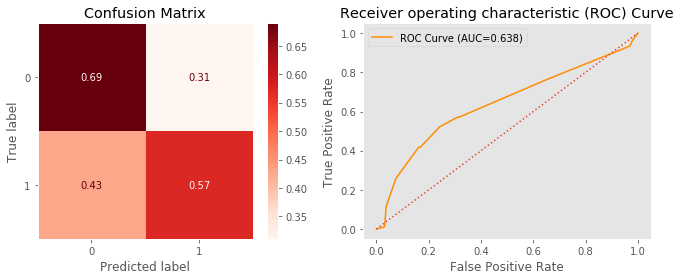

Impressions    0.638307
Spent          0.097156
fb_counts      0.052861
interest_22    0.048444
interest_65    0.043624
Name: Importance, dtype: float64


In [32]:
evaluate_model(clf, y_train, y_test, y_hat_test, X_train, X_test)

## First Decision Tree model shows mediocre results. The model scored 73% on the training data and 60% on the testing data. While the scores indicate that the model did slightly overfit, it only performed slightly better than 60% on recall. It did a descent job predicting true False (69%) however it fell short in predicting true Positive (54%). The most influenctial predictor by far is Impressions.

# Visualize Tree

In [33]:
visualize_tree(tree,feature_names=X_train.columns,save_filename='Tree')

[i] Tree saved as Tree.png


# Random Forest Model

In [34]:
rf = RandomForestClassifier()

In [35]:
y_hat_test, clf = run_model(rf, X_train, y_train, X_test)

[i] Timer started at05/09/20 - 03:57 PM
[i] Timer ended at 05/09/20 - 03:57 PM
- Total time = 0:00:00.434319


# Random Forest Results

Train score= 1.0
Test score= 0.6209912536443148
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       161
           1       0.66      0.59      0.62       182

    accuracy                           0.62       343
   macro avg       0.62      0.62      0.62       343
weighted avg       0.63      0.62      0.62       343



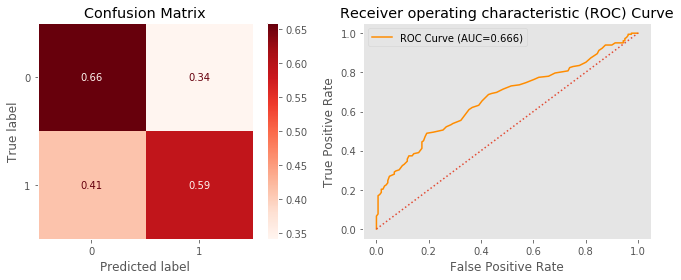

Impressions    0.237549
Spent          0.169973
Clicks         0.125345
age_number     0.064129
fb_counts      0.061935
Name: Importance, dtype: float64


In [36]:
evaluate_model(clf, y_train, y_test,y_hat_test,X_train, X_test)

## Random Forest overtrained the test data, indicated by a Train Score of 1. The results were surprisingly similar to a plain Decision Tree with exception of the overtrained Train data. Clicks did make a showing in the top three pedictors, where it had not in the past.

# RF Grid Search

In [37]:
tree = RandomForestClassifier()

# Set up param grid

param_grid = {'criterion':['gini','entropy'],
             'max_depth':[None, 5, 3, 10],
             'max_features':['auto','sqrt',3,5,10,30,70],
              'min_samples_leaf': [1,2,3]}

grid_clf = GridSearchCV(tree,param_grid)

In [38]:
timer = Timer()
timer.start()

grid_clf.fit(X_train, y_train)

timer.stop()

grid_clf.best_params_

[i] Timer started at05/09/20 - 03:57 PM
[i] Timer ended at 05/09/20 - 04:00 PM
- Total time = 0:02:28.373187


{'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 3}

In [39]:
# Create a tree with the gridsearch's best params

best_tree = RandomForestClassifier(**grid_clf.best_params_)

In [40]:
# Create a tree with the gridsearch's best params

timer = Timer()
timer.start()

best_tree.fit(X_train,y_train)

timer.stop()

[i] Timer started at05/09/20 - 04:00 PM
[i] Timer ended at 05/09/20 - 04:00 PM
- Total time = 0:00:00.254472


# RF Grid Search Results

Train score= 0.66875
Test score= 0.6297376093294461
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       161
           1       0.66      0.59      0.62       182

    accuracy                           0.62       343
   macro avg       0.62      0.62      0.62       343
weighted avg       0.63      0.62      0.62       343



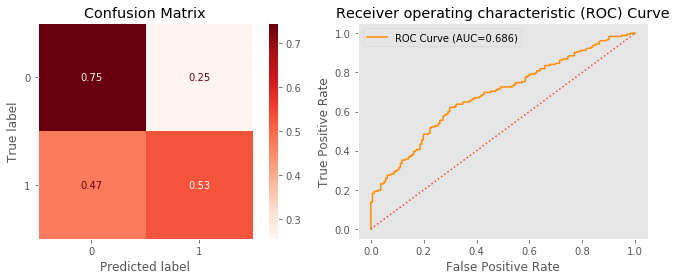

Impressions             0.211500
Clicks                  0.164893
Spent                   0.160731
xyz_campaign_id_1178    0.085943
fb_counts               0.077420
Name: Importance, dtype: float64


In [41]:
evaluate_model(best_tree, y_train, y_test, y_hat_test,X_train, X_test)

## Similiar results to D. Tree Grid Search; slight over train of training data. .58 recall.

# XGBOOST Model

In [42]:
xgb_rf = XGBRFClassifier()

In [43]:
y_hat_test, clf = run_model(xgb_rf, X_train, y_train, X_test)

[i] Timer started at05/09/20 - 04:00 PM
[i] Timer ended at 05/09/20 - 04:00 PM
- Total time = 0:00:00.177372


# XGBOOST Results

Train score= 0.6725
Test score= 0.6297376093294461
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       161
           1       0.71      0.52      0.60       182

    accuracy                           0.63       343
   macro avg       0.64      0.64      0.63       343
weighted avg       0.65      0.63      0.63       343



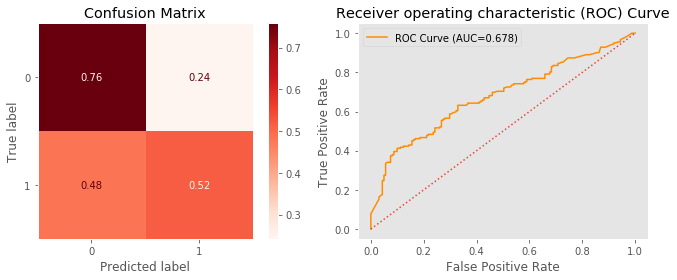

xyz_campaign_id_1178    0.185928
Impressions             0.182246
Spent                   0.099423
Clicks                  0.082680
interest_22             0.059030
Name: Importance, dtype: float32


In [44]:
evaluate_model(clf,y_train, y_test,y_hat_test,X_train, X_test)

## Average results; very low True Positive results.

# XGBOOST RF Model

In [45]:
xgbrf_grid = {'colsample_bynode': 0.8, 'learning_rate': .1,
              'max_depth': 5, 'num_parallel_tree': 100, 
              'objective': 'binary:logistic', 'subsample': 0.8}

xrf_clf = XGBRFClassifier(**xgbrf_grid)

In [46]:
timer = Timer()
timer.start()

xrf_clf = XGBRFClassifier(**xgbrf_grid)
xrf_clf.fit(X_train,y_train)

timer.stop()
grid_clf.best_params_

[i] Timer started at05/09/20 - 04:00 PM
[i] Timer ended at 05/09/20 - 04:00 PM
- Total time = 0:00:00.242973


{'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 3}

# XGBOOST RF Results

Train score= 0.7025
Test score= 0.6472303206997084
              precision    recall  f1-score   support

           0       0.60      0.76      0.67       161
           1       0.72      0.54      0.62       182

    accuracy                           0.65       343
   macro avg       0.66      0.65      0.65       343
weighted avg       0.66      0.65      0.64       343



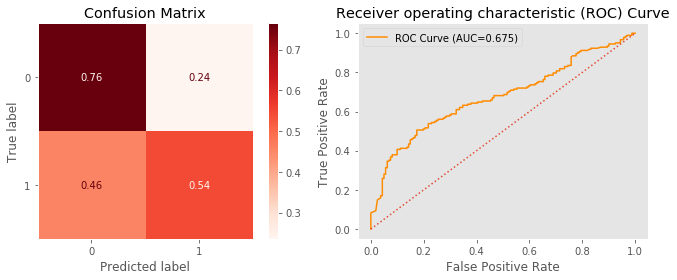

xyz_campaign_id_1178    0.127751
Impressions             0.105624
interest_22             0.053771
Spent                   0.052579
interest_65             0.046007
Name: Importance, dtype: float32


In [47]:
y_hat_test = xrf_clf.predict(X_test)

evaluate_model(xrf_clf, y_train, y_test,y_hat_test,X_train, X_test)

## Overtrained training set and very low True Positive results.

# Final Results

# For the business problem of identifying which variables contribute to classifying if customers make a purchase; Grid Search CV on a Decision Tree model had the best results of all the models tried. The training and test score are both mid to low .60's indicating that the model did not over or unerfit the traing data and had a siliar result on the test data. The recall score of .68 indicates a 18% improvement of identifying True Posisitives from random chance. The top three predictors have a linear relationship, in that Impressions, Spent and Clicks are all correlated.

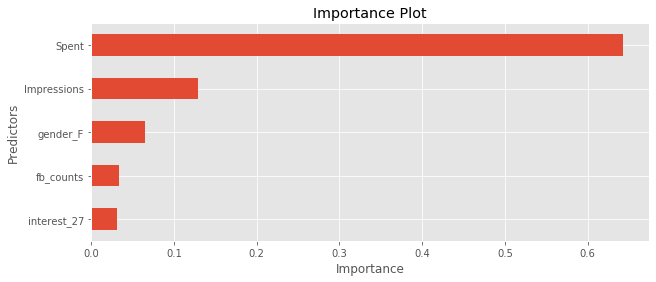

In [58]:
   
    fig, ax = plt.subplots(figsize=(10,4))
    df_import = pd.Series(best_tree.feature_importances_, index = X_train.columns,name='Importance')
    (df_import.sort_values(ascending=True).tail()).plot(kind = 'barh')
    xaxis = 'Importance'
    ax.set(ylabel='Predictors',xlabel='Importance',title='Importance Plot');

In [88]:
df.corr().loc['Spent'][:5]

Impressions            0.970386
Clicks                 0.992906
Spent                  1.000000
Approved_Conversion    0.281179
fb_counts              0.372407
Name: Spent, dtype: float64

# Grid Search CV Model

In [54]:
tree = DecisionTreeClassifier()
# Set up param grid

param_grid = {'criterion':['gini','entropy'],
             'max_depth':[None, 5, 3, 10],
             'max_features':['auto','sqrt',3,5,10,30,70],
              'min_samples_leaf': [1,2,3]}

grid_clf = GridSearchCV(tree,param_grid)# scoring='recall')

In [55]:
timer = Timer()
timer.start()

# Fit Grid Search to Decission Tree.

grid_clf.fit(X_train,y_train)

timer.stop()
grid_clf.best_params_

[i] Timer started at05/09/20 - 04:01 PM
[i] Timer ended at 05/09/20 - 04:01 PM
- Total time = 0:00:04.078932


{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2}

In [56]:
# Create a tree with the gridsearch's best params

best_tree = DecisionTreeClassifier(**grid_clf.best_params_)
best_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Grid Search CV Results

Train score= 0.6525
Test score= 0.6064139941690962
              precision    recall  f1-score   support

           0       0.56      0.80      0.66       161
           1       0.71      0.43      0.54       182

    accuracy                           0.61       343
   macro avg       0.63      0.62      0.60       343
weighted avg       0.64      0.61      0.59       343



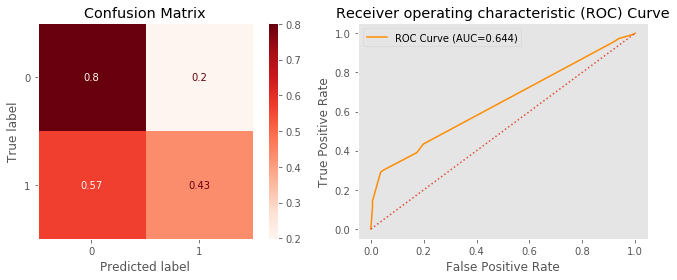

Spent          0.642087
Impressions    0.128466
gender_F       0.065153
fb_counts      0.033580
interest_27    0.031535
Name: Importance, dtype: float64


In [57]:
y_hat_test = best_tree.predict(X_test)

evaluate_model(best_tree, y_train, y_test,y_hat_test,X_train, X_test)